Credit-Card Fraud Detection Modeling & Fine-Tuning
==================================================

Intro
-----
In this notebook, I'll be training various models on the *creditcard* data using their defaults, and I'll be selecting the model with the best result for fine-tuning and evaluation. I'll then save this model to disk after.

- Due to the high imbalance in the data, I'll be using the *roc_auc*, *ave_precision*, and *f1* scores
- Using _selected features_ don't seem to improve performance. I'll be using all the available features for modeling

In [1]:
# import necessary libraries
import numpy as np
import pandas as pd
from IPython.display import Markdown, display

In [2]:
# function to print markdown text
def printmd(string):
    display(Markdown(string))

Load Data
---------

In [3]:
# read data from `creditcard.csv`
df = pd.read_csv('./data/creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


#### Split Data to *train, test, val* and Scale

In [4]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [5]:
# seperate data to Dependent & Independent features
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

# split to train, test, val
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.4, random_state=21)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, stratify=y_test, test_size=0.3, random_state=21)

In [6]:
print("COMPLETE DATA", y.value_counts())
print()
print("TRAIN DATA", y_train.value_counts())
print()
print("TEST DATA", y_test.value_counts())
print()
print("VAL DATA", y_val.value_counts())

COMPLETE DATA Class
0    284315
1       492
Name: count, dtype: int64

TRAIN DATA Class
0    170589
1       295
Name: count, dtype: int64

TEST DATA Class
0    79608
1      138
Name: count, dtype: int64

VAL DATA Class
0    34118
1       59
Name: count, dtype: int64


In [7]:
# create scaler object
minmax_scaler = MinMaxScaler()

# fit & transform X_train
X_train_sc = minmax_scaler.fit_transform(X_train)
X_train_sc = pd.DataFrame(X_train_sc, columns=minmax_scaler.get_feature_names_out())

# transform X_test
X_test_sc = minmax_scaler.transform(X_test)
X_test_sc = pd.DataFrame(X_test_sc, columns=minmax_scaler.get_feature_names_out())

# transform X_val
X_val_sc = minmax_scaler.transform(X_val)
X_val_sc = pd.DataFrame(X_val_sc, columns=minmax_scaler.get_feature_names_out())

In [8]:
# dump minmax_scaler to disk as 'minmax_scaler.gz'
import joblib
joblib.dump(minmax_scaler, "minmax_scaler.gz")

['minmax_scaler.gz']

In [9]:
X_train_sc.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,0.497838,0.978987,0.768361,0.910681,0.259919,0.768480,0.260650,0.267697,0.795064,0.546514,...,0.581043,0.555464,0.451621,0.664537,0.270681,0.675381,0.455882,0.236520,0.313074,0.002370
1,0.546141,0.997793,0.752824,0.869728,0.141701,0.775795,0.295071,0.256449,0.802863,0.544616,...,0.575978,0.560168,0.528133,0.667203,0.471026,0.656895,0.434004,0.237900,0.311629,0.000584
2,0.210762,0.980858,0.764030,0.900579,0.197104,0.777388,0.295564,0.260607,0.805510,0.574650,...,0.581028,0.558520,0.478391,0.666268,0.524345,0.667509,0.575622,0.236729,0.313197,0.000299
3,0.223842,0.984311,0.755273,0.917645,0.177344,0.759078,0.262566,0.258884,0.796328,0.482804,...,0.577258,0.560167,0.514639,0.661943,0.268101,0.690265,0.428053,0.238806,0.313064,0.001148
4,0.739228,0.938248,0.766586,0.956478,0.224037,0.771381,0.260746,0.264836,0.799033,0.580530,...,0.581781,0.565225,0.535278,0.659993,0.462800,0.699382,0.406849,0.239229,0.314798,0.000448


In [10]:
X_test_sc.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,0.389289,0.947475,0.779054,0.936598,0.286222,0.765077,0.262659,0.266710,0.803184,0.526417,...,0.578100,0.565814,0.538653,0.664599,0.381663,0.626160,0.373831,0.239574,0.314872,0.000698
1,0.342306,0.941543,0.785300,0.929826,0.293452,0.762161,0.254883,0.266571,0.803009,0.520607,...,0.578041,0.565722,0.535218,0.664534,0.438620,0.637403,0.369106,0.233564,0.313820,0.000854
2,0.804175,0.941327,0.755735,0.877610,0.182042,0.779659,0.300406,0.276476,0.804031,0.545071,...,0.592454,0.571696,0.555548,0.682121,0.478404,0.606781,0.523169,0.244807,0.320018,0.018483
3,0.931031,0.953650,0.775970,0.930156,0.268993,0.774763,0.282969,0.267316,0.802026,0.526404,...,0.582099,0.567065,0.564280,0.657154,0.261479,0.681881,0.516128,0.241507,0.314089,0.000111
4,0.317941,0.923170,0.770470,0.926884,0.312500,0.773481,0.254383,0.261729,0.793562,0.518542,...,0.577129,0.576449,0.514750,0.656927,0.406148,0.637780,0.378239,0.246845,0.307248,0.000039


In [11]:
X_val_sc.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,0.198221,0.977919,0.762998,0.941089,0.257270,0.758698,0.263152,0.260786,0.798369,0.608870,...,0.579521,0.560131,0.508616,0.666631,0.404562,0.652541,0.591773,0.237942,0.313427,0.000716
1,0.190396,0.934936,0.775040,0.933110,0.335098,0.776307,0.310672,0.260662,0.814094,0.519868,...,0.583320,0.563134,0.524273,0.666292,0.520285,0.676002,0.495082,0.242813,0.313851,0.003343
2,0.341507,0.978308,0.768187,0.935638,0.293462,0.761846,0.261649,0.262720,0.798199,0.572580,...,0.578706,0.560904,0.503002,0.665628,0.375882,0.669753,0.342711,0.239379,0.313575,0.000194
3,0.453969,0.906190,0.779580,0.889763,0.197436,0.748296,0.250869,0.263546,0.811278,0.583621,...,0.575153,0.562630,0.521996,0.668715,0.448390,0.643249,0.419651,0.221100,0.302295,0.005697
4,0.241257,0.941992,0.758143,0.957727,0.277778,0.758151,0.264771,0.269656,0.795429,0.509317,...,0.583327,0.561960,0.516998,0.674650,0.423817,0.633675,0.381807,0.236489,0.311963,0.011054


Train model using their default values
--------------------------------------

some models I'll be using include
- LogisticRegression
- RandomForestClassifier
- GradientBoostingClassifier
- XGBClassifier

*would have loved to experiment with the LinearRegression and LinearSVC models, but they can't predict probabilities which is necessary for the metrics I'm using*

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier

from sklearn import metrics

In [13]:
def metrics_report(y_true, y_score, thresh=0.5, return_vals=False):
    # auc, f1-score, ave-precision
    roc_auc = metrics.roc_auc_score(y_true, y_score)
    ave_precision = metrics.average_precision_score(y_true, y_score)
    y_pred = (y_score >= thresh).astype(int)
    f1 = metrics.f1_score(y_true, y_pred)

    if return_vals:
        return roc_auc, ave_precision, f1
    else:
        printmd(f'''
---------------------------------------------------
| roc_auc_score | ave_precision_score  | f1_score |
|--------------:|---------------------:|---------:|
| {roc_auc:.4f} | {ave_precision:.4f} | {f1:.4f} |
''')

In [14]:
def train_model(model, train, test):
    # X_train & y_train from train
    X_tr, y_tr = train
    # X_test & y_test from train
    X_te, y_te = test

    model.fit(X_tr, y_tr)

    printmd("**REPORT ON TRAIN**")
    metrics_report(y_tr, model.predict_proba(X_tr)[:, 1])
    # print(classification_report(y_tr, model.predict(X_tr), target_names=['GENUINE', 'FRAUD']))

    printmd("**REPORT ON TEST**")
    metrics_report(y_te, model.predict_proba(X_te)[:, 1])
    # print(classification_report(y_te, model.predict(X_te), target_names=['GENUINE', 'FRAUD']))

#### LOGISTIC REGRESSION *results for positive class (fraud) on X_test*
------------------------------------------------------------
| DATA                    | roc_auc_score | ave_precision_score  | f1_score |
|-------------------------|----------:|--------:|---------:|
| UNSCALED (ALL FEAT.)    | 0.8763 | 0.5618 | 0.6667 |
| SCALED (ALL FEAT.)      | 0.9740 | 0.7098 | 0.6182 |

###### training *UNSCALED* data with *ALL* features

In [15]:
lr_model1 = LogisticRegression(random_state=21)
train_model(lr_model1, (X_train, y_train), (X_test, y_test))

**REPORT ON TRAIN**


---------------------------------------------------
| roc_auc_score | ave_precision_score  | f1_score |
|--------------:|---------------------:|---------:|
| 0.9238 | 0.6828 | 0.7844 |


**REPORT ON TEST**


---------------------------------------------------
| roc_auc_score | ave_precision_score  | f1_score |
|--------------:|---------------------:|---------:|
| 0.8763 | 0.5618 | 0.6667 |


###### training *SCALED* data with *ALL* features

In [16]:
lr_model2 = LogisticRegression(random_state=21)
train_model(lr_model2, (X_train_sc, y_train), (X_test_sc, y_test))

**REPORT ON TRAIN**


---------------------------------------------------
| roc_auc_score | ave_precision_score  | f1_score |
|--------------:|---------------------:|---------:|
| 0.9806 | 0.7488 | 0.6820 |


**REPORT ON TEST**


---------------------------------------------------
| roc_auc_score | ave_precision_score  | f1_score |
|--------------:|---------------------:|---------:|
| 0.9740 | 0.7098 | 0.6182 |


#### RANDOM FOREST *results for positive class (fraud) on X_test*
------------------------------------------------------------
| DATA                    | roc_auc_score | ave_precision_score  | f1_score |
|-------------------------|----------:|--------:|---------:|
| UNSCALED (ALL FEAT.)    | 0.9365 | 0.8032 | 0.8000 |
| SCALED (ALL FEAT.)      | 0.9402 | 0.8043 | 0.8000 |

###### training *UNSCALED* data with *ALL* features

In [17]:
rf_model1 = RandomForestClassifier(random_state=21)
train_model(rf_model1, (X_train, y_train), (X_test, y_test))

**REPORT ON TRAIN**


---------------------------------------------------
| roc_auc_score | ave_precision_score  | f1_score |
|--------------:|---------------------:|---------:|
| 1.0000 | 1.0000 | 0.9983 |


**REPORT ON TEST**


---------------------------------------------------
| roc_auc_score | ave_precision_score  | f1_score |
|--------------:|---------------------:|---------:|
| 0.9365 | 0.8032 | 0.8000 |


###### training *SCALED* data with *ALL* features

In [18]:
rf_model2 = RandomForestClassifier(random_state=21)
train_model(rf_model2, (X_train_sc, y_train), (X_test_sc, y_test))

**REPORT ON TRAIN**


---------------------------------------------------
| roc_auc_score | ave_precision_score  | f1_score |
|--------------:|---------------------:|---------:|
| 1.0000 | 1.0000 | 0.9983 |


**REPORT ON TEST**


---------------------------------------------------
| roc_auc_score | ave_precision_score  | f1_score |
|--------------:|---------------------:|---------:|
| 0.9402 | 0.8043 | 0.8000 |


#### GRADIENT BOOSTING *results for positive class (fraud) on X_test*
------------------------------------------------------------
| DATA                    | roc_auc_score | ave_precision_score  | f1_score |
|-------------------------|----------:|--------:|---------:|
| UNSCALED (ALL FEAT.)    | 0.8364 | 0.5758 | 0.7200 |
| SCALED (ALL FEAT.)      | 0.8364 | 0.5758 | 0.7200 |

###### training *UNSCALED* data with *ALL* features

In [19]:
gbc_model1 = GradientBoostingClassifier(random_state=21)
train_model(gbc_model1, (X_train, y_train), (X_test, y_test))

**REPORT ON TRAIN**


---------------------------------------------------
| roc_auc_score | ave_precision_score  | f1_score |
|--------------:|---------------------:|---------:|
| 0.8217 | 0.6367 | 0.7466 |


**REPORT ON TEST**


---------------------------------------------------
| roc_auc_score | ave_precision_score  | f1_score |
|--------------:|---------------------:|---------:|
| 0.8364 | 0.5758 | 0.7200 |


###### training *SCALED* data with *ALL* features

In [20]:
gbc_model2 = GradientBoostingClassifier(random_state=21)
train_model(gbc_model2, (X_train_sc, y_train), (X_test_sc, y_test))

**REPORT ON TRAIN**


---------------------------------------------------
| roc_auc_score | ave_precision_score  | f1_score |
|--------------:|---------------------:|---------:|
| 0.8217 | 0.6367 | 0.7466 |


**REPORT ON TEST**


---------------------------------------------------
| roc_auc_score | ave_precision_score  | f1_score |
|--------------:|---------------------:|---------:|
| 0.8364 | 0.5758 | 0.7200 |


#### XGBOOST *results for positive class (fraud) on X_test*
------------------------------------------------------------
| DATA                    | roc_auc_score | ave_precision_score  | f1_score |
|-------------------------|----------:|--------:|---------:|
| UNSCALED (ALL FEAT.)    | 0.9712 | 0.8224 | 0.8333 |
| SCALED (ALL FEAT.)      | 0.9715 | 0.8156 | 0.8300 |

###### training *UNSCALED* data with *ALL* features

In [21]:
xgb_model1 = XGBClassifier(random_state=21)
train_model(xgb_model1, (X_train, y_train), (X_test, y_test))

**REPORT ON TRAIN**


---------------------------------------------------
| roc_auc_score | ave_precision_score  | f1_score |
|--------------:|---------------------:|---------:|
| 1.0000 | 1.0000 | 1.0000 |


**REPORT ON TEST**


---------------------------------------------------
| roc_auc_score | ave_precision_score  | f1_score |
|--------------:|---------------------:|---------:|
| 0.9712 | 0.8224 | 0.8333 |


###### training *SCALED* data with *ALL* features

In [22]:
xgb_model2 = XGBClassifier(random_state=21)
train_model(xgb_model2, (X_train_sc, y_train), (X_test_sc, y_test))

**REPORT ON TRAIN**


---------------------------------------------------
| roc_auc_score | ave_precision_score  | f1_score |
|--------------:|---------------------:|---------:|
| 1.0000 | 1.0000 | 1.0000 |


**REPORT ON TEST**


---------------------------------------------------
| roc_auc_score | ave_precision_score  | f1_score |
|--------------:|---------------------:|---------:|
| 0.9715 | 0.8156 | 0.8300 |


#### Model Evaluation
From the model training, the best-performing model considering the 3 metrics is the **XGBClassifer**. This was kind of expected cos of its efficiency and gradient boosting.
- The **RandomForestClassifier** also does well, but it has a long training-time
- The **LogisticRegressionClassifier** also has a good performance on the _roc_auc_score_, but not so good enough on the other metrics

This affirms the choice of the **XGBClassifier**. Another thing is I'll be sticking with the unscaled data as there's no much of a performance increase after scaling which is not worth the resources it takes up

Fine-tuning the best model (XGBoost)
------------------------------------

The **XGBClassifier** have 3 categories of parameters
1. _General_ parameters: guides the overall functioning
2. _Booster_ parameters: guides the individual booster _(tree/regression)_ at each step
3. _Learning-Task_ parameters: guides the optimization performed

In [23]:
import xgboost as xgb
import matplotlib.pylab as plt

from pprint import pprint
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import GridSearchCV

In [24]:
def plot_roc(fpr, tpr, roc_auc):
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], 'k--')

    # set x & y lim
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])

    plt.xlabel('false positive rate (FPR)')
    plt.ylabel('true positive rate (TPR)')
    plt.title(f'ROC curve (area = {roc_auc:.6f})')
    # plt.legend(loc='best')
    
    plt.show()

def plot_pr(recall, precision, ave_precision):
    plt.step(recall, precision, color='b', alpha=0.2, where='post')
    plt.fill_between(recall, precision, color='b', alpha=0.2, step='post')

    # set x & y lim
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])

    plt.xlabel('recall')
    plt.ylabel('precision')
    plt.title(f'Precision-Recall: {ave_precision:.6f}')

    plt.show()

def plot_learning_curve(results, epochs):
    x_axis = range(0, epochs)
    # fig, ax = plt.subplot()

    plt.plot(x_axis, results['validation_0']['logloss'], label='logloss-train')
    plt.plot(x_axis, results['validation_1']['logloss'], label='logloss-test')
    plt.plot(x_axis, results['validation_0']['auc'], label='auc-train')
    plt.plot(x_axis, results['validation_1']['auc'], label='auc-test')

    plt.legend(loc='best')
    
    plt.ylabel('logloss | auc')
    plt.title('XGB logloss & auc evolution')

    plt.show()

In [25]:
def plot_param_eval(param, results):
    # this function can be optimized; it plots the evaluation results of the
    # parameters optimized
    param_keys = list(param.keys())

    # plot when there's a single parameter being tuned
    if len(param_keys) == 1:
        plt.title('GridSearchCV `f1` & `roc_auc` Evaluation', fontsize=16)
        pk = param_keys[0]
        plt.xlabel(pk)
        plt.ylabel('Score')
        
        ax = plt.gca()
        # change parameter values in range to list
        if type(param[pk]) == range:
            param[pk] = list(param[pk])
        ax.set_xlim(param[pk][0], param[pk][-1])
        ax.set_ylim(0.75, 1.1)
        
        # get the regular numpy array from the MaskedArray
        x_axis = np.array(results[f'param_{pk}'].data, dtype=float)

        for scorer, color in zip(sorted(['roc_auc', 'f1']), ['b', 'g']):
            for sample, style in (('train', '--'), ('test', '-')):
                # ss -> sample_score
                ss_mean = results[f'mean_{sample}_{scorer}']
                ss_std = results[f'std_{sample}_{scorer}']
                ax.fill_between(x_axis, 
                                ss_mean-ss_std, ss_mean+ss_std, 
                                alpha=0.1 if sample=='test' else 0, 
                                color=color)
                ax.plot(x_axis, ss_mean, 
                        style, color=color, 
                        alpha=1 if sample=='test' else 0.7, 
                        label=f'{scorer} ({sample})')
            
            best_index = np.nonzero(results[f'rank_test_{scorer}'] == 1)[0][0]
            best_score = results[f'mean_test_{scorer}'][best_index]
        
            # plot a dotted vertical line at the best-score for the scorer marked by `x`
            ax.plot([x_axis[best_index], ]*2, [0, best_score], 
                    linestyle='-.', 
                    color=color, 
                    marker='x', 
                    markeredgewidth=3, ms=8)
            # annotate the best-score for that scorer
            ax.annotate(f'{best_score:.2f}', (x_axis[best_index], best_score+0.005))

        ax.legend(loc="best")
        ax.grid(False)

    # plot when there are multi-parameters being tuned
    else:
        fig, axs = plt.subplots(1, len(param_keys), sharey=True)
        fig.suptitle('GridSearchCV `f1` & `roc_auc` Evaluation', fontsize=16)
    
        for ax, pk in zip(axs, param_keys):
            ax.set(xlabel=pk, ylabel='Score')
            # change parameter values in range to list
            if type(param[pk]) == range:
                param[pk] = list(param[pk])
            ax.set(xlim=(param[pk][0], param[pk][-1]), ylim=(0.75, 1.1))

            # get the regular numpy array from the MaskedArray
            x_axis = np.array(results[f'param_{pk}'].data, dtype=float)

            for scorer, color in zip(sorted(['roc_auc', 'f1']), ['b', 'g']):
                for sample, style in (('train', '--'), ('test', '-')):
                    # ss -> sample_score
                    ss_mean = results[f'mean_{sample}_{scorer}']
                    ss_std = results[f'std_{sample}_{scorer}']
                    ax.fill_between(x_axis, 
                                    ss_mean-ss_std, ss_mean+ss_std, 
                                    alpha=0.1 if sample=='test' else 0, 
                                    color=color)
                    ax.plot(x_axis, ss_mean, 
                            style, color=color, 
                            alpha=1 if sample=='test' else 0.7, 
                            label=f'{scorer} ({sample})')
            
                best_index = np.nonzero(results[f'rank_test_{scorer}'] == 1)[0][0]
                best_score = results[f'mean_test_{scorer}'][best_index]
        
                # plot a dotted vertical line at the best-score for the scorer marked by `x`
                ax.plot([x_axis[best_index], ]*2, [0, best_score], 
                        linestyle='-.', 
                        color=color, 
                        marker='x', 
                        markeredgewidth=3, ms=8)
                # annotate the best-score for that scorer
                ax.annotate(f'{best_score:.2f}', (x_axis[best_index], best_score+0.005))

            ax.legend(loc="best")
            ax.grid(False)

    plt.show()

In [26]:
def fit_model(model, train, test, use_cv=True, early_stopping_rounds=10, show_plots=True):
    # X, y from train
    X_tr, y_tr = train
    # X, y from test
    X_te, y_te = test
    
    if use_cv:
        xgb_params = model.get_xgb_params()
        xgb_dtrain = xgb.DMatrix(X_tr.values, label=y_tr.values)

        cv_result = xgb.cv(xgb_params, xgb_dtrain, 
                           num_boost_round=model.n_estimators,
                           nfold=5, seed=21, metrics='auc', 
                           early_stopping_rounds=early_stopping_rounds)
        print(cv_result.tail(1))
        model.set_params(n_estimators=cv_result.shape[0])

    # fit model
    model.set_params(eval_metric=['auc', 'error', 'logloss'], early_stopping_rounds=25)
    model.fit(X_tr, y_tr, eval_set=[train, test], verbose=False)

    # predict & report test data
    printmd('> **MODEL REPORT on _test_**')
    y_pred = model.predict_proba(X_te)[:, 1]
    fpr, tpr, _ = metrics.roc_curve(y_te, y_pred)
    roc_auc = metrics.auc(fpr, tpr)
    ave_precision = metrics.average_precision_score(y_te, y_pred)
    precision, recall, _ = metrics.precision_recall_curve(y_te, y_pred)

    if show_plots:
        # plot roc curve
        plot_roc(fpr, tpr, roc_auc)
        # plot precision-recall
        plot_pr(recall, precision, ave_precision)
        # plot learning-curve
        results = model.evals_result()
        epochs = len(results['validation_0']['error'])
        plot_learning_curve(results, epochs)
    else:
        print(f'ROC curve (area = {roc_auc:.6f})')
        print(f'Precision-Recall: {ave_precision:.6f}')

#### General Approach for Fine-tuning
1. choose a relatively high _learning_rate_ - A _learning_rate_ of **0.1** works, but a value between **0.05-0.3** should work for different problems. I will determine the optimum _n_estimators_ for this lr using XGB's _cv_ function which performs cross-validation at each boosting iteration
2. tune tree-specific parameters _(max_depth, min_child_weight, gamma, subsample, colsample_bytree)_ for the decided _learning_rate_ and optimum _n_estimators_
3. tune regularization parameters _(lambda, alpha)_ for the model - This can help reduce model complexity and enhance performance
4. lower the _learning_rate_ on decided optimum parameters

##### step 1: fix _learning_rate_ and _n_estimators_ for tuning tree-specific parameters
to decide on _Booster_ parameters, one needs to set initial values for the other parameters; say:
- **max_depth=5** can be between 3-10
- **min_child_weight=1** a smaller value is good for this highly imbalanced class problem, and leaf nodes can have smaller size groups
- **gamma=0** can be between 0-0.2; this will be tuned
- **subsample=0.8** & **colsample_bytree=0.8** this is a typical start value; can be between 0.5-0.9
- **scale_pos_weight=1** also because of high class imbalance

    train-auc-mean  train-auc-std  test-auc-mean  test-auc-std
63        0.998868       0.000694       0.982581      0.011436


> **MODEL REPORT on _test_**

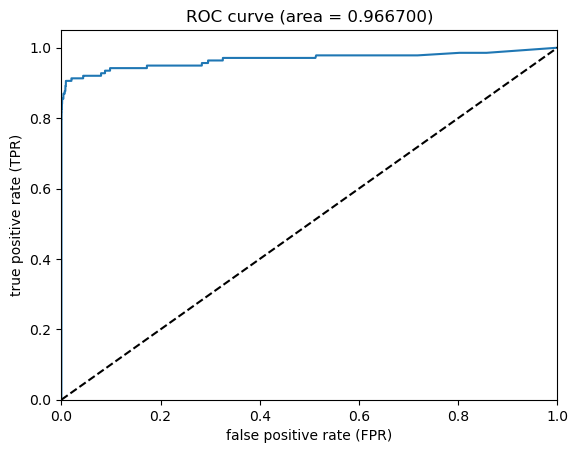

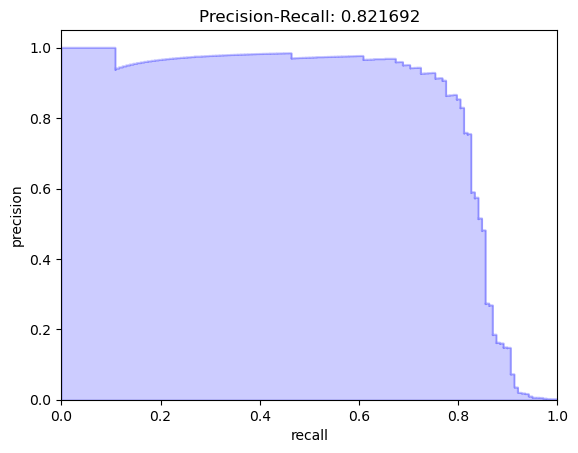

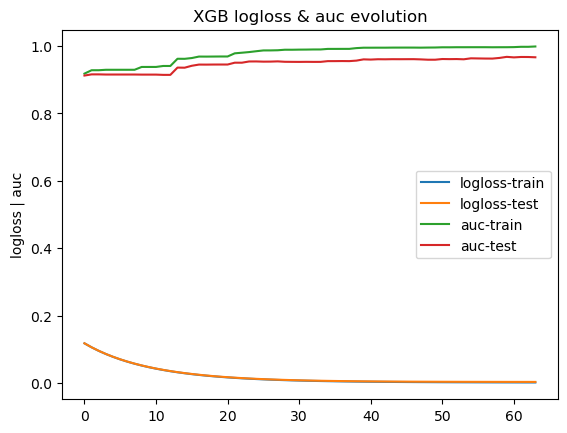

In [27]:
xgb_step1 = XGBClassifier(
    learning_rate=0.1,
    n_estimators=1000,
    max_depth=5,
    min_child_weight=1,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='binary:logistic',
    scale_pos_weight=1,
    nthread=-1,
    seed=21
)

fit_model(xgb_step1, (X_train, y_train), (X_test, y_test))

In [28]:
# predict & report val data
printmd('###### _xgb_step1_ MODEL REPORT on _X_val_')
s1_pred = xgb_step1.predict_proba(X_val)[:, 1]
roc_auc_s1 = metrics.roc_auc_score(y_val, s1_pred)
ave_precision_s1 = metrics.average_precision_score(y_val, s1_pred)

print(f'ROC curve (area = {roc_auc_s1:.6f})')
print(f'Precision-Recall: {ave_precision_s1:.6f}')

###### _xgb_step1_ MODEL REPORT on _X_val_

ROC curve (area = 0.975182)
Precision-Recall: 0.850074


##### step 2: tune _max_depth_ and _min_child_weight_
these parameters will be tuned first as they have the highest impact on the model outcome; to start with, using **learning_rate=0.1** & **n_estimators=64**, I'll set wider ranges and perform another iteration for smaller ranges 

In [29]:
param_step2 = {
    'max_depth': range(3, 10, 2),
    'min_child_weight': range(1, 6, 2)
}

xgb_step2 = XGBClassifier(**xgb_step1.get_params())

gs_step2 = GridSearchCV(
    estimator=xgb_step2, 
    param_grid=param_step2, 
    scoring=['roc_auc', 'f1'], 
    return_train_score=True, verbose=False,
    refit='roc_auc', n_jobs=-1, cv=5
)
gs_step2.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)])
results_step2 = gs_step2.cv_results_

[0]	validation_0-auc:0.91809	validation_0-error:0.00173	validation_0-logloss:0.11763	validation_1-auc:0.91239	validation_1-error:0.00173	validation_1-logloss:0.11766
[1]	validation_0-auc:0.92822	validation_0-error:0.00173	validation_0-logloss:0.10573	validation_1-auc:0.91593	validation_1-error:0.00173	validation_1-logloss:0.10584
[2]	validation_0-auc:0.92824	validation_0-error:0.00173	validation_0-logloss:0.09520	validation_1-auc:0.91595	validation_1-error:0.00173	validation_1-logloss:0.09534
[3]	validation_0-auc:0.92956	validation_0-error:0.00173	validation_0-logloss:0.08583	validation_1-auc:0.91549	validation_1-error:0.00173	validation_1-logloss:0.08597
[4]	validation_0-auc:0.92956	validation_0-error:0.00173	validation_0-logloss:0.07744	validation_1-auc:0.91549	validation_1-error:0.00173	validation_1-logloss:0.07761
[5]	validation_0-auc:0.92956	validation_0-error:0.00105	validation_0-logloss:0.06993	validation_1-auc:0.91549	validation_1-error:0.00123	validation_1-logloss:0.07013
[6]	

**max_depth: 3**

**min_child_weight: 5**

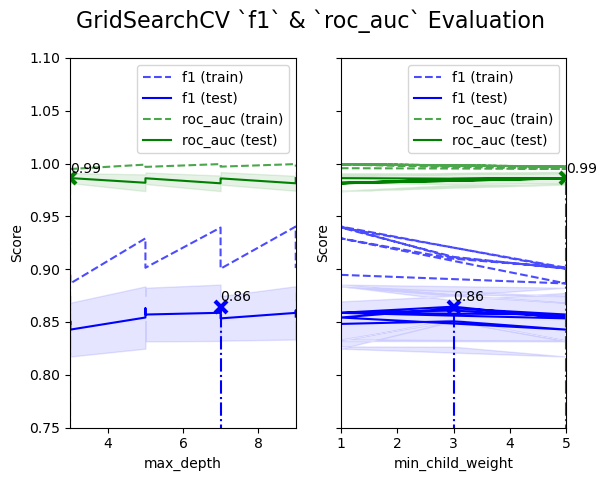

In [30]:
for key, value in gs_step2.best_params_.items():
    printmd(f'**{key}: {value}**')
plot_param_eval(param_step2, results_step2)

##### step 3: tune _gamma_
next is tuning _gamma_ using the already tuned **max_depth=3** & **min_child_weight=5**

In [31]:
param_step3 = {
    'gamma': [i/10.0 for i in range(5)]
}

xgb_step3 = XGBClassifier(**xgb_step2.get_params())
xgb_step3.set_params(max_depth=3, min_child_weight=5)


gs_step3 = GridSearchCV(
    estimator=xgb_step3, 
    param_grid=param_step3, 
    scoring=['roc_auc', 'f1'], 
    return_train_score=True, verbose=False,
    refit='roc_auc', n_jobs=-1, cv=5
)
gs_step3.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)])
results_step3 = gs_step3.cv_results_

[0]	validation_0-auc:0.91809	validation_0-error:0.00173	validation_0-logloss:0.11763	validation_1-auc:0.91239	validation_1-error:0.00173	validation_1-logloss:0.11766
[1]	validation_0-auc:0.92822	validation_0-error:0.00173	validation_0-logloss:0.10573	validation_1-auc:0.91593	validation_1-error:0.00173	validation_1-logloss:0.10584
[2]	validation_0-auc:0.92824	validation_0-error:0.00173	validation_0-logloss:0.09520	validation_1-auc:0.91595	validation_1-error:0.00173	validation_1-logloss:0.09534
[3]	validation_0-auc:0.92956	validation_0-error:0.00173	validation_0-logloss:0.08583	validation_1-auc:0.91549	validation_1-error:0.00173	validation_1-logloss:0.08597
[4]	validation_0-auc:0.92956	validation_0-error:0.00173	validation_0-logloss:0.07744	validation_1-auc:0.91549	validation_1-error:0.00173	validation_1-logloss:0.07761
[5]	validation_0-auc:0.92956	validation_0-error:0.00105	validation_0-logloss:0.06993	validation_1-auc:0.91549	validation_1-error:0.00123	validation_1-logloss:0.07013
[6]	

###### gamma: 0.2

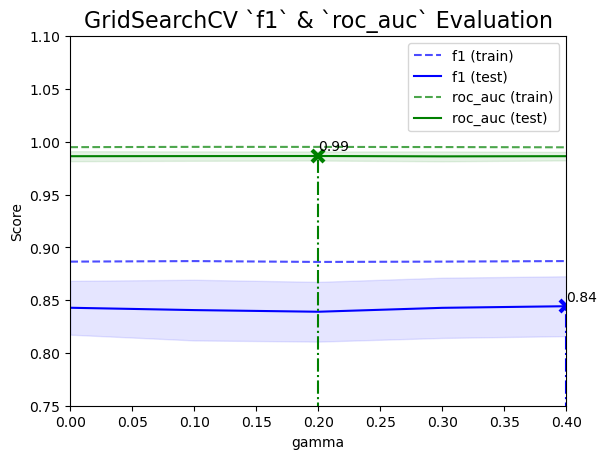

In [32]:
for key, value in gs_step3.best_params_.items():
    printmd(f'###### {key}: {value}')
plot_param_eval(param_step3, results_step3)

##### step 4: train model with tuned parameters
I'll train the model using parameters I've tuned and test on _X_val_; these are:
- ###### max_depth=3
- ###### min_child_weight=5
- ###### gamma=0.2

    train-auc-mean  train-auc-std  test-auc-mean  test-auc-std
61        0.993948       0.001506       0.986186      0.006797


> **MODEL REPORT on _test_**

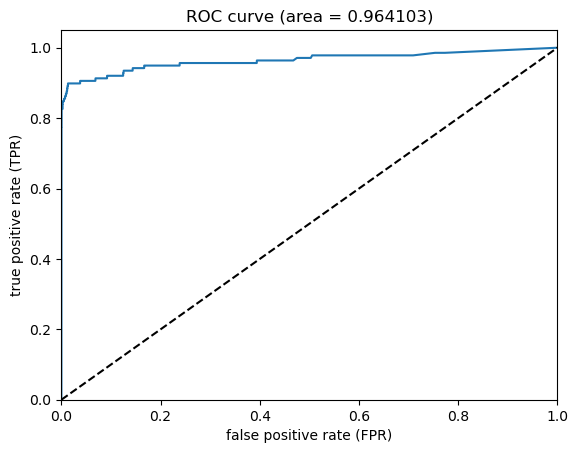

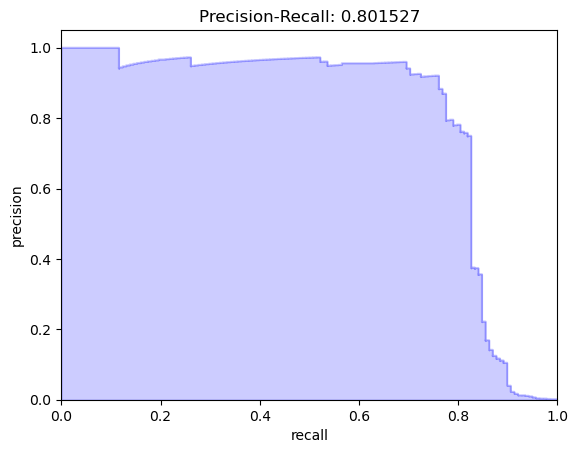

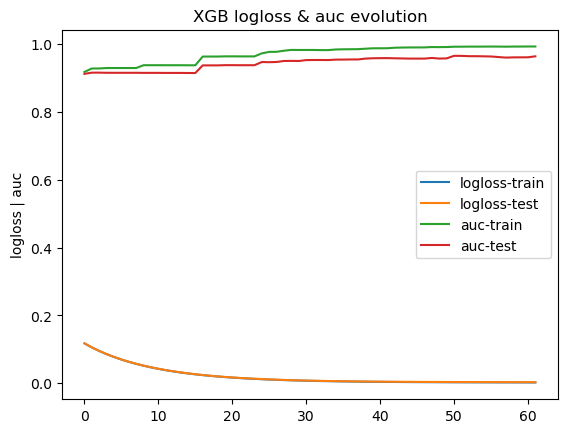

In [33]:
xgb_step4 = XGBClassifier(
    learning_rate=0.1,
    n_estimators=1000,
    max_depth=3,
    min_child_weight=5,
    gamma=0.2,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='binary:logistic',
    scale_pos_weight=1,
    nthread=-1,
    seed=21
)

fit_model(xgb_step4, (X_train, y_train), (X_test, y_test))

In [34]:
# predict & report val data
printmd('##### _xgb_step4_ MODEL REPORT on _X_val_')
s4_pred = xgb_step4.predict_proba(X_val)[:, 1]
roc_auc_s4 = metrics.roc_auc_score(y_val, s4_pred)
ave_precision_s4 = metrics.average_precision_score(y_val, s4_pred)

print(f'ROC curve (area = {roc_auc_s4:.6f})')
print(f'Precision-Recall: {ave_precision_s4:.6f}')

##### _xgb_step4_ MODEL REPORT on _X_val_

ROC curve (area = 0.968799)
Precision-Recall: 0.848295


##### step 5: tune _subsample_ and _colsample_bytree_
next is to tune the _subsample_ and _colsample_bytree_ parameters using the tuned paramater values:
- ###### max_depth=3
- ###### min_child_weight=5
- ###### gamma=0.2

In [35]:
param_step5 = {
    'subsample': [i/10 for i in range(6, 10)],
    'colsample_bytree': [i/10 for i in range(6, 10)]
}

xgb_step5 = XGBClassifier(**xgb_step4.get_params())

gs_step5 = GridSearchCV(
    estimator=xgb_step5, 
    param_grid=param_step5, 
    scoring=['roc_auc', 'f1'], 
    return_train_score=True, verbose=False,
    refit='roc_auc', n_jobs=-1, cv=5
)
gs_step5.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)])
results_step5 = gs_step5.cv_results_

[0]	validation_0-auc:0.91812	validation_0-error:0.00173	validation_0-logloss:0.11759	validation_1-auc:0.91242	validation_1-error:0.00173	validation_1-logloss:0.11765
[1]	validation_0-auc:0.92822	validation_0-error:0.00173	validation_0-logloss:0.10573	validation_1-auc:0.91594	validation_1-error:0.00173	validation_1-logloss:0.10584
[2]	validation_0-auc:0.92824	validation_0-error:0.00173	validation_0-logloss:0.09520	validation_1-auc:0.91595	validation_1-error:0.00173	validation_1-logloss:0.09534
[3]	validation_0-auc:0.93802	validation_0-error:0.00173	validation_0-logloss:0.08584	validation_1-auc:0.91542	validation_1-error:0.00173	validation_1-logloss:0.08600
[4]	validation_0-auc:0.93801	validation_0-error:0.00173	validation_0-logloss:0.07745	validation_1-auc:0.91543	validation_1-error:0.00173	validation_1-logloss:0.07763
[5]	validation_0-auc:0.93801	validation_0-error:0.00107	validation_0-logloss:0.06994	validation_1-auc:0.91543	validation_1-error:0.00119	validation_1-logloss:0.07014
[6]	

###### colsample_bytree: 0.9

###### subsample: 0.8

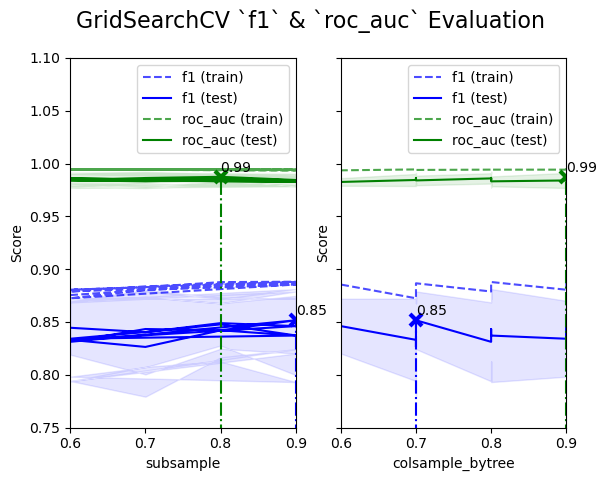

In [36]:
for key, value in gs_step5.best_params_.items():
    printmd(f'###### {key}: {value}')
plot_param_eval(param_step5, results_step5)

##### step 6: tune regularization parameters
I'll be tuning the _reg_alpha_, a regularization parameter to reduce overfitting. I'll use the tuned paramater values:
- ###### max_depth=3
- ###### min_child_weight=5
- ###### gamma=0.2
- ###### colsample_bytree=0.9
- ###### subsample=0.8

In [37]:
param_step6 = {
    'reg_alpha': [1e-5, 1e-2, 0.1, 1, 100]
}

xgb_step6 = XGBClassifier(**xgb_step4.get_params())
xgb_step6.set_params(colsample_bytree=0.9, subsample=0.8)

gs_step6 = GridSearchCV(
    estimator=xgb_step6, 
    param_grid=param_step6, 
    scoring=['roc_auc', 'f1'], 
    return_train_score=True, verbose=False,
    refit='roc_auc', n_jobs=-1, cv=5
)
gs_step6.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)])
results_step6 = gs_step6.cv_results_

[0]	validation_0-auc:0.91812	validation_0-error:0.00173	validation_0-logloss:0.11759	validation_1-auc:0.91242	validation_1-error:0.00173	validation_1-logloss:0.11765
[1]	validation_0-auc:0.92822	validation_0-error:0.00173	validation_0-logloss:0.10573	validation_1-auc:0.91594	validation_1-error:0.00173	validation_1-logloss:0.10584
[2]	validation_0-auc:0.92824	validation_0-error:0.00173	validation_0-logloss:0.09520	validation_1-auc:0.91595	validation_1-error:0.00173	validation_1-logloss:0.09534
[3]	validation_0-auc:0.93802	validation_0-error:0.00173	validation_0-logloss:0.08584	validation_1-auc:0.91542	validation_1-error:0.00173	validation_1-logloss:0.08600
[4]	validation_0-auc:0.93801	validation_0-error:0.00173	validation_0-logloss:0.07745	validation_1-auc:0.91543	validation_1-error:0.00173	validation_1-logloss:0.07763
[5]	validation_0-auc:0.93801	validation_0-error:0.00107	validation_0-logloss:0.06994	validation_1-auc:0.91543	validation_1-error:0.00119	validation_1-logloss:0.07014
[6]	

###### reg_alpha: 1e-05

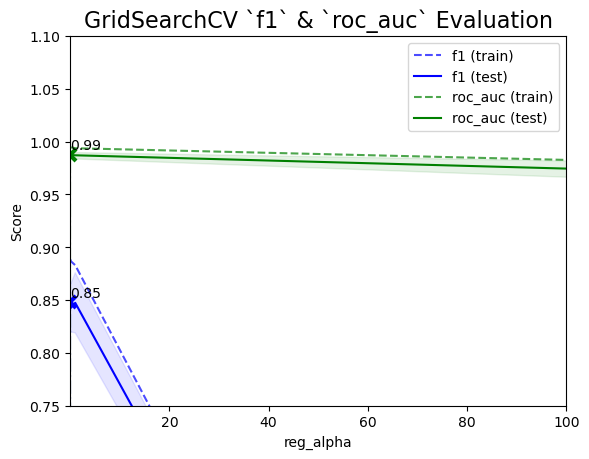

In [38]:
for key, value in gs_step6.best_params_.items():
    printmd(f'###### {key}: {value}')
plot_param_eval(param_step6, results_step6)

##### step 7: train model with tuned parameters
I'll train the model using parameters I've tuned and test on _X_val_; these are:
- ###### max_depth=3
- ###### min_child_weight=5
- ###### gamma=0.2
- ###### colsample_bytree=0.9
- ###### subsample=0.8
- ###### reg_alpha=1e-05

    train-auc-mean  train-auc-std  test-auc-mean  test-auc-std
61        0.993948       0.001506       0.986186      0.006797


> **MODEL REPORT on _test_**

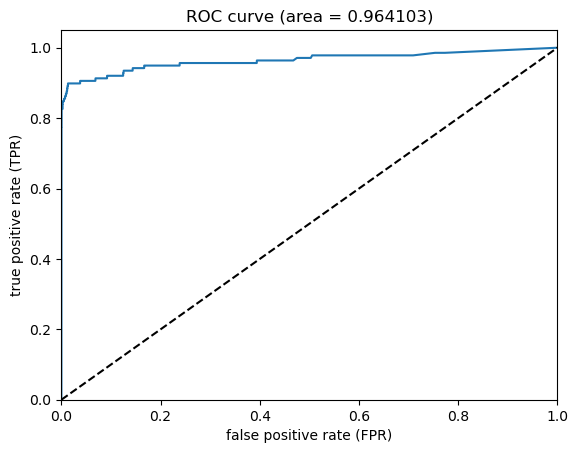

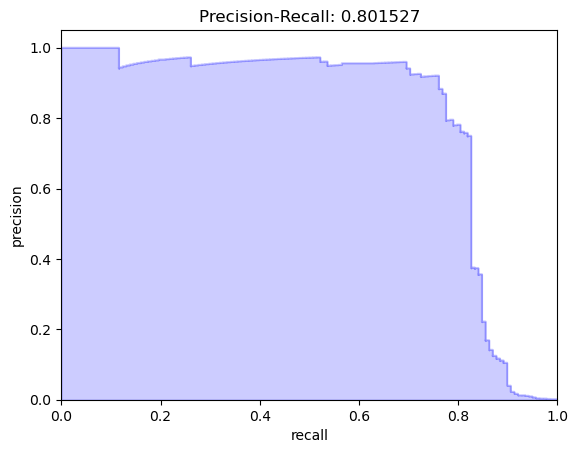

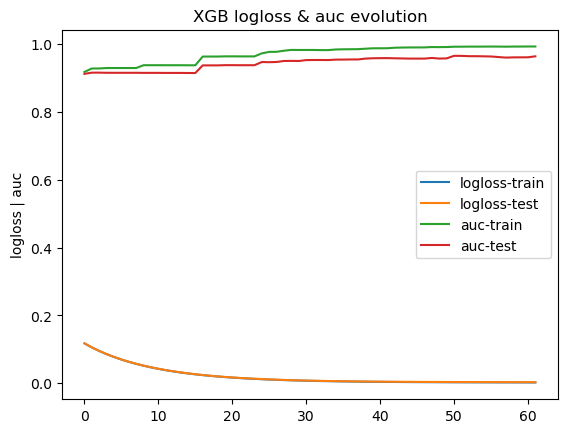

In [39]:
xgb_step7 = XGBClassifier(
    learning_rate=0.1,
    n_estimators=1000,
    max_depth=3,
    min_child_weight=5,
    gamma=0.2,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=1e-05,
    objective='binary:logistic',
    scale_pos_weight=1,
    nthread=-1,
    seed=21
)

fit_model(xgb_step7, (X_train, y_train), (X_test, y_test))

In [40]:
# predict & report val data
printmd('###### _xgb_step7_ MODEL REPORT on _X_val_')
s7_pred = xgb_step7.predict_proba(X_val)[:, 1]
roc_auc_s7 = metrics.roc_auc_score(y_val, s7_pred)
ave_precision_s7 = metrics.average_precision_score(y_val, s7_pred)

print(f'ROC curve (area = {roc_auc_s7:.6f})')
print(f'Precision-Recall: {ave_precision_s7:.6f}')

###### _xgb_step7_ MODEL REPORT on _X_val_

ROC curve (area = 0.968799)
Precision-Recall: 0.848295


##### step 8: reduce the _learning_rate_ and increase the _n_estimators_
this is a good _auc_ score, but I'll try to lower the learning-rate and add more trees to see if that makes a noteable difference

    train-auc-mean  train-auc-std  test-auc-mean  test-auc-std
29        0.932898       0.006048       0.930474      0.024077


> **MODEL REPORT on _test_**

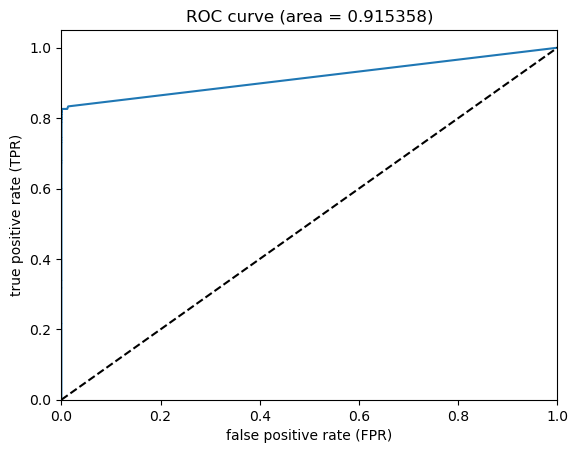

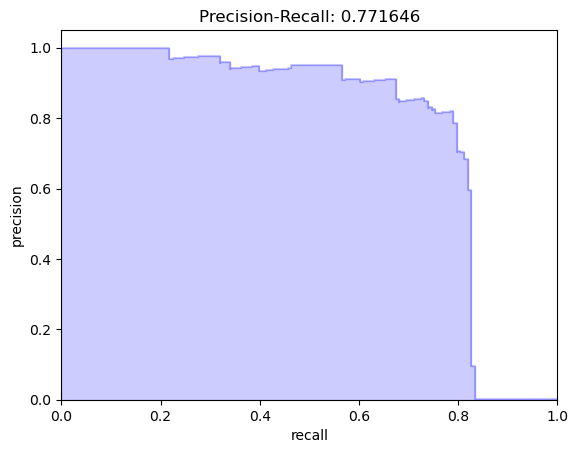

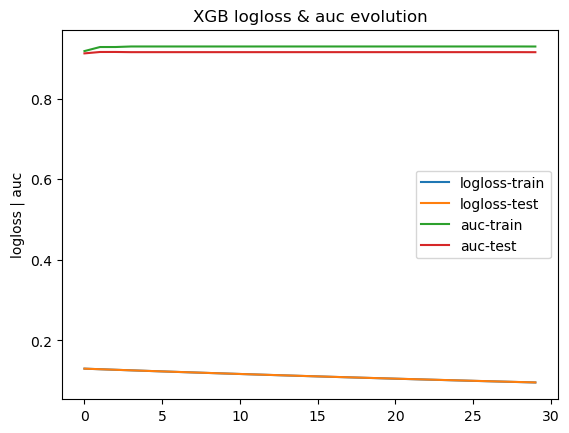

In [41]:
xgb_step8a = XGBClassifier(
    learning_rate=0.01,
    n_estimators=5000,
    max_depth=3,
    min_child_weight=5,
    gamma=0.2,
    subsample=0.8,
    colsample_bytree=0.9,
    reg_alpha=1e-05,
    objective='binary:logistic',
    scale_pos_weight=1,
    nthread=-1,
    seed=21
)

fit_model(xgb_step8a, (X_train, y_train), (X_test, y_test))

In [42]:
# predict & report val data
printmd('###### _xgb_step8a_ MODEL REPORT on _X_val_')
s8_pred = xgb_step8a.predict_proba(X_val)[:, 1]
roc_auc_s8 = metrics.roc_auc_score(y_val, s8_pred)
ave_precision_s8 = metrics.average_precision_score(y_val, s8_pred)

print(f'ROC curve (area = {roc_auc_s8:.6f})')
print(f'Precision-Recall: {ave_precision_s8:.6f}')

###### _xgb_step8a_ MODEL REPORT on _X_val_

ROC curve (area = 0.939788)
Precision-Recall: 0.817341


    train-auc-mean  train-auc-std  test-auc-mean  test-auc-std
51        0.998275       0.000629       0.988444       0.00674


> **MODEL REPORT on _test_**

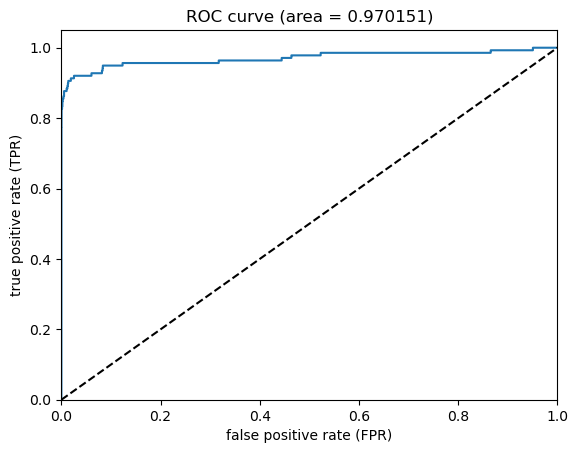

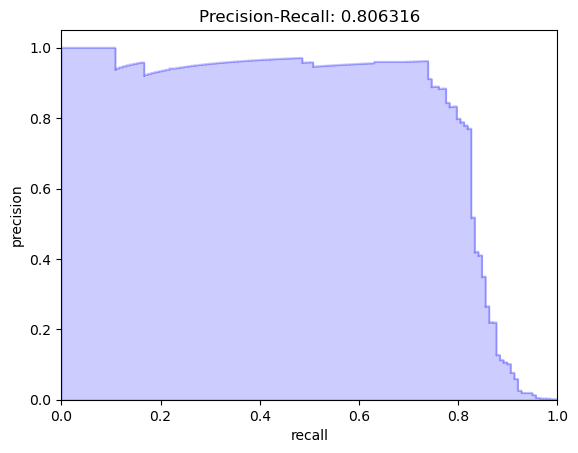

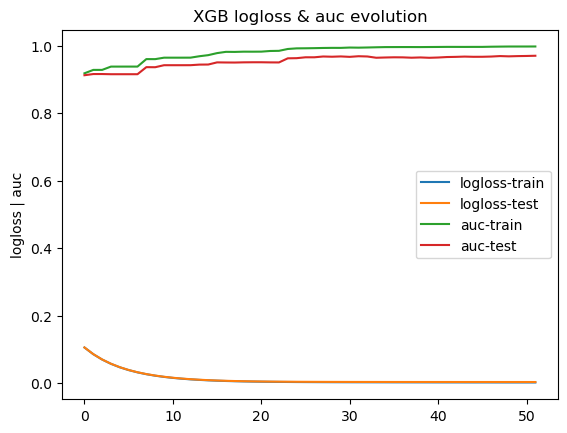

In [43]:
xgb_step8b = XGBClassifier(
    learning_rate=0.2,
    n_estimators=5000,
    max_depth=3,
    min_child_weight=5,
    gamma=0.2,
    subsample=0.8,
    colsample_bytree=0.9,
    reg_alpha=1e-05,
    objective='binary:logistic',
    scale_pos_weight=1,
    nthread=-1,
    seed=21
)

fit_model(xgb_step8b, (X_train, y_train), (X_test, y_test))

In [44]:
# predict & report val data
printmd('###### _xgb_step8b_ MODEL REPORT on _X_val_')
s8_pred = xgb_step8b.predict_proba(X_val)[:, 1]
roc_auc_s8 = metrics.roc_auc_score(y_val, s8_pred)
ave_precision_s8 = metrics.average_precision_score(y_val, s8_pred)

print(f'ROC curve (area = {roc_auc_s8:.6f})')
print(f'Precision-Recall: {ave_precision_s8:.6f}')

###### _xgb_step8b_ MODEL REPORT on _X_val_

ROC curve (area = 0.980415)
Precision-Recall: 0.835672


>I decreased the _learning_rate_ to *0.01* and increased the _n_estimators_ to *5000*. The _auc_ significantly decreased to **0.939788** from **0.968799** and the _ave_precision_ also decreased to **0.817341** from **0.848295**

>I also tried increasing the _learning_rate_ to *0.2* and the _n_estimators_ to *5000*. The _auc_ significantly increased to **0.980415** from **0.968799** and the _ave_precision_ decreased to **0.835672** from **0.848295**

    In conclusion, since I consider the auc score more relevant for this problem statement, I'll be using the 0.2 learning_rate i.e. the xgb_step8b

#### Evaluating the fine-tuned model
I'll be checking the performance of the fine-tuned model - **xgb_step8b** and analyzing it's ability to detect fraud in the right situation

In [45]:
def xgb_predict(model, x, thresh=0.5):
    pred = (model.predict_proba(x)[:, 1] > thresh).astype(int)
    
    return pred

In [46]:
thresholds = [i/100 for i in range(50, 95, 5)]
table = pd.DataFrame(columns=['thresh', 'roc_auc', 
                              'ave_precision', 'f1', 
                              'true_pos', 'false_pos', 
                              'true_neg', 'false_neg'])

for i in thresholds:
    y_score = xgb_predict(xgb_step8b, X_val, thresh=i)
    roc_auc, ave_precision, f1 = metrics_report(y_val, y_score, thresh=i, return_vals=True)
    tn, fp, fn, tp = metrics.confusion_matrix(y_val, y_score).ravel()

    new_row = {'thresh': i, 'roc_auc': roc_auc, 
               'ave_precision': ave_precision, 'f1': f1, 
               'true_pos': tp, 'false_pos': fp, 
               'true_neg': tn, 'false_neg': fn}
    table.loc[len(table)] = new_row
    
printmd('''
> **true_pos**: where the transaction is _fraudulent_ and the model predicted _fraudulent_
> **false_pos**: where the transaction is _genuine_ and the model predicted _fraudulent_
> **true_neg**: where the transaction is _genuine_ and the model predicted _genuine_   
> **false_neg**: where the transaction is _fraudulent_ and the model predicted _genuine_
''')
table


> **true_pos**: where the transaction is _fraudulent_ and the model predicted _fraudulent_
> **false_pos**: where the transaction is _genuine_ and the model predicted _fraudulent_
> **true_neg**: where the transaction is _genuine_ and the model predicted _genuine_   
> **false_neg**: where the transaction is _fraudulent_ and the model predicted _genuine_


,thresh,roc_auc,ave_precision,f1,true_pos,false_pos,true_neg,false_neg
0,0.50,0.915196,0.768121,0.875000,49,4,34114,10
1,0.55,0.906721,0.751300,0.864865,48,4,34114,11
2,0.60,0.906736,0.766025,0.872727,48,3,34115,11
3,0.65,0.906736,0.766025,0.872727,48,3,34115,11
4,0.70,0.906750,0.781339,0.880734,48,2,34116,11
5,0.75,0.889816,0.763453,0.867925,46,1,34117,13
6,0.80,0.864392,0.712718,0.834951,43,1,34117,16
7,0.85,0.838968,0.661986,0.800000,40,1,34117,19
8,0.90,0.796596,0.577444,0.736842,35,1,34117,24


Conclusion
----------

There are two threshold values I consider as best: at **thresh=0.5** and **thresh=0.7**
1. when _thresh=0.5_, this has the best number of _true_positive_ and also the best number of _false_negative_; in this case, security is it top-most
2. when _thresh=0.7_, this has the best _ave_precision_ and _f1_ values, i.e. it tries so much to make sure that a transaction is fraudulent before calling in; in this case customer-experience is top-most

Choosing between these two thresholds depends on the company type and nature of business

In [47]:
# saving final xgb model to disk
joblib.dump(xgb_step8b, 'xgb-model.gz')

['xgb-model.gz']